In [1]:
import torch as t

#### 全连接

In [4]:
class MyLinear(t.nn.Module):
    def __init__(self,in_features,out_features):
        super(MyLinear,self).__init__()
        self.w = t.nn.Parameter(t.randn(in_features,out_features))
        self.b = t.nn.Parameter(t.randn(out_features))
    
    def forward(self,x):
        x = x.mm(self.w)
        return x + self.b.expand_as(x)

In [5]:
linear = MyLinear(4,3)

In [6]:
x = t.randn(4)

In [7]:
x.unsqueeze_(0)
x

tensor([[ 0.5617,  1.6909,  0.1872, -2.0603]])

In [8]:
out = linear(x)
out

tensor([[-1.3715,  0.7391,  6.0691]], grad_fn=<ThAddBackward>)

#### 多层感知器

In [9]:
class Perceptron(t.nn.Module):
    def __init__(self,in_features,hidden_size,out_features):
        super(Perceptron,self).__init__()
        self.layer1 = MyLinear(in_features,hidden_size)
        self.layer2 = MyLinear(hidden_size,out_features)
    
    def forward(self,x):
        x = t.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [10]:
x = t.randn(3,4)

In [11]:
net = Perceptron(4,8,2)

In [12]:
out = net(x)

In [13]:
out

tensor([[ 1.0715, -1.5594],
        [-4.0721,  0.8847],
        [ 0.1985, -0.3292]], grad_fn=<ThAddBackward>)

##### 卷积神经网络

In [14]:
from PIL import Image

In [22]:
from torchvision.transforms import ToTensor,ToPILImage,CenterCrop

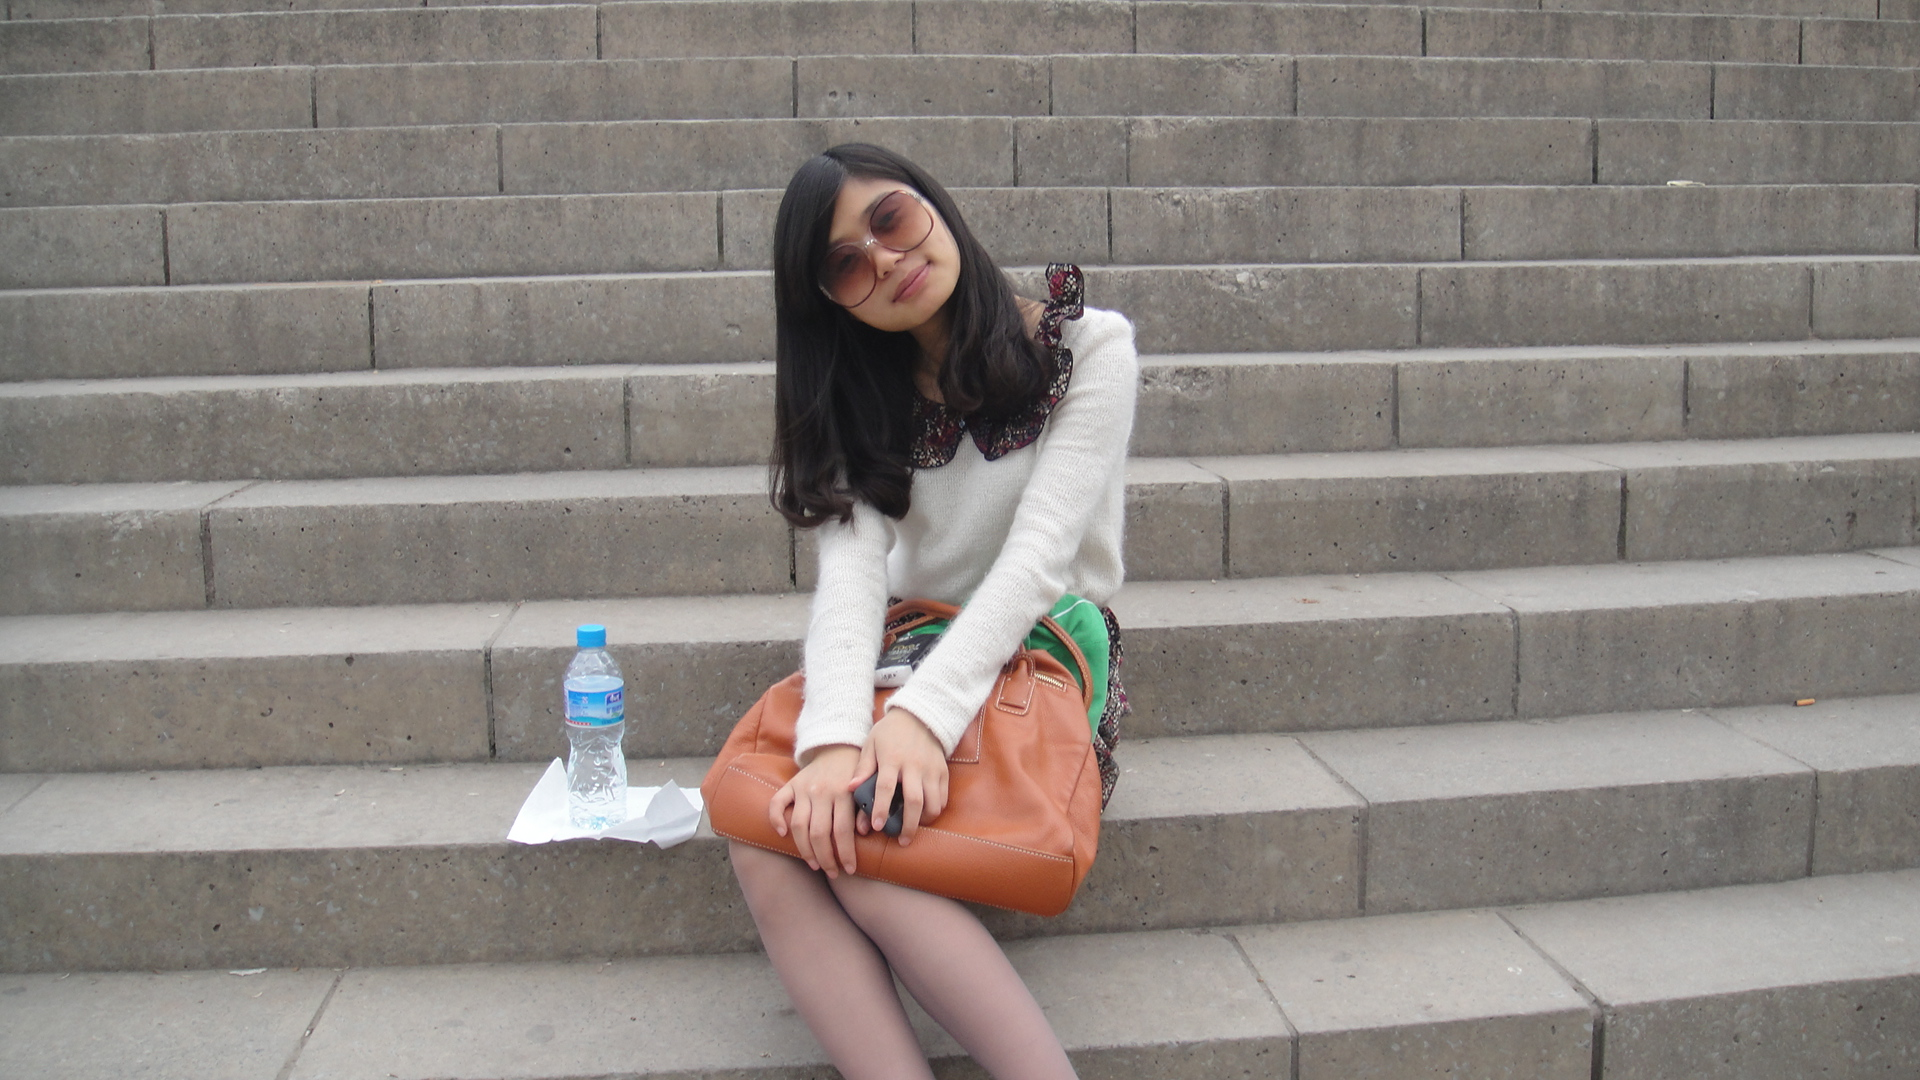

In [16]:
img = Image.open("./data/DSC05076.JPG")
img

In [23]:
to_tensor = ToTensor()
to_pil = ToPILImage()
center_crop = CenterCrop(224)

In [25]:
x = to_tensor(img).unsqueeze(0)

In [21]:
kernel = t.tensor([3,3])

In [29]:
conv = t.nn.Conv2d(3,3,kernel_size=kernel,bias=False)

In [30]:
out = conv(x)

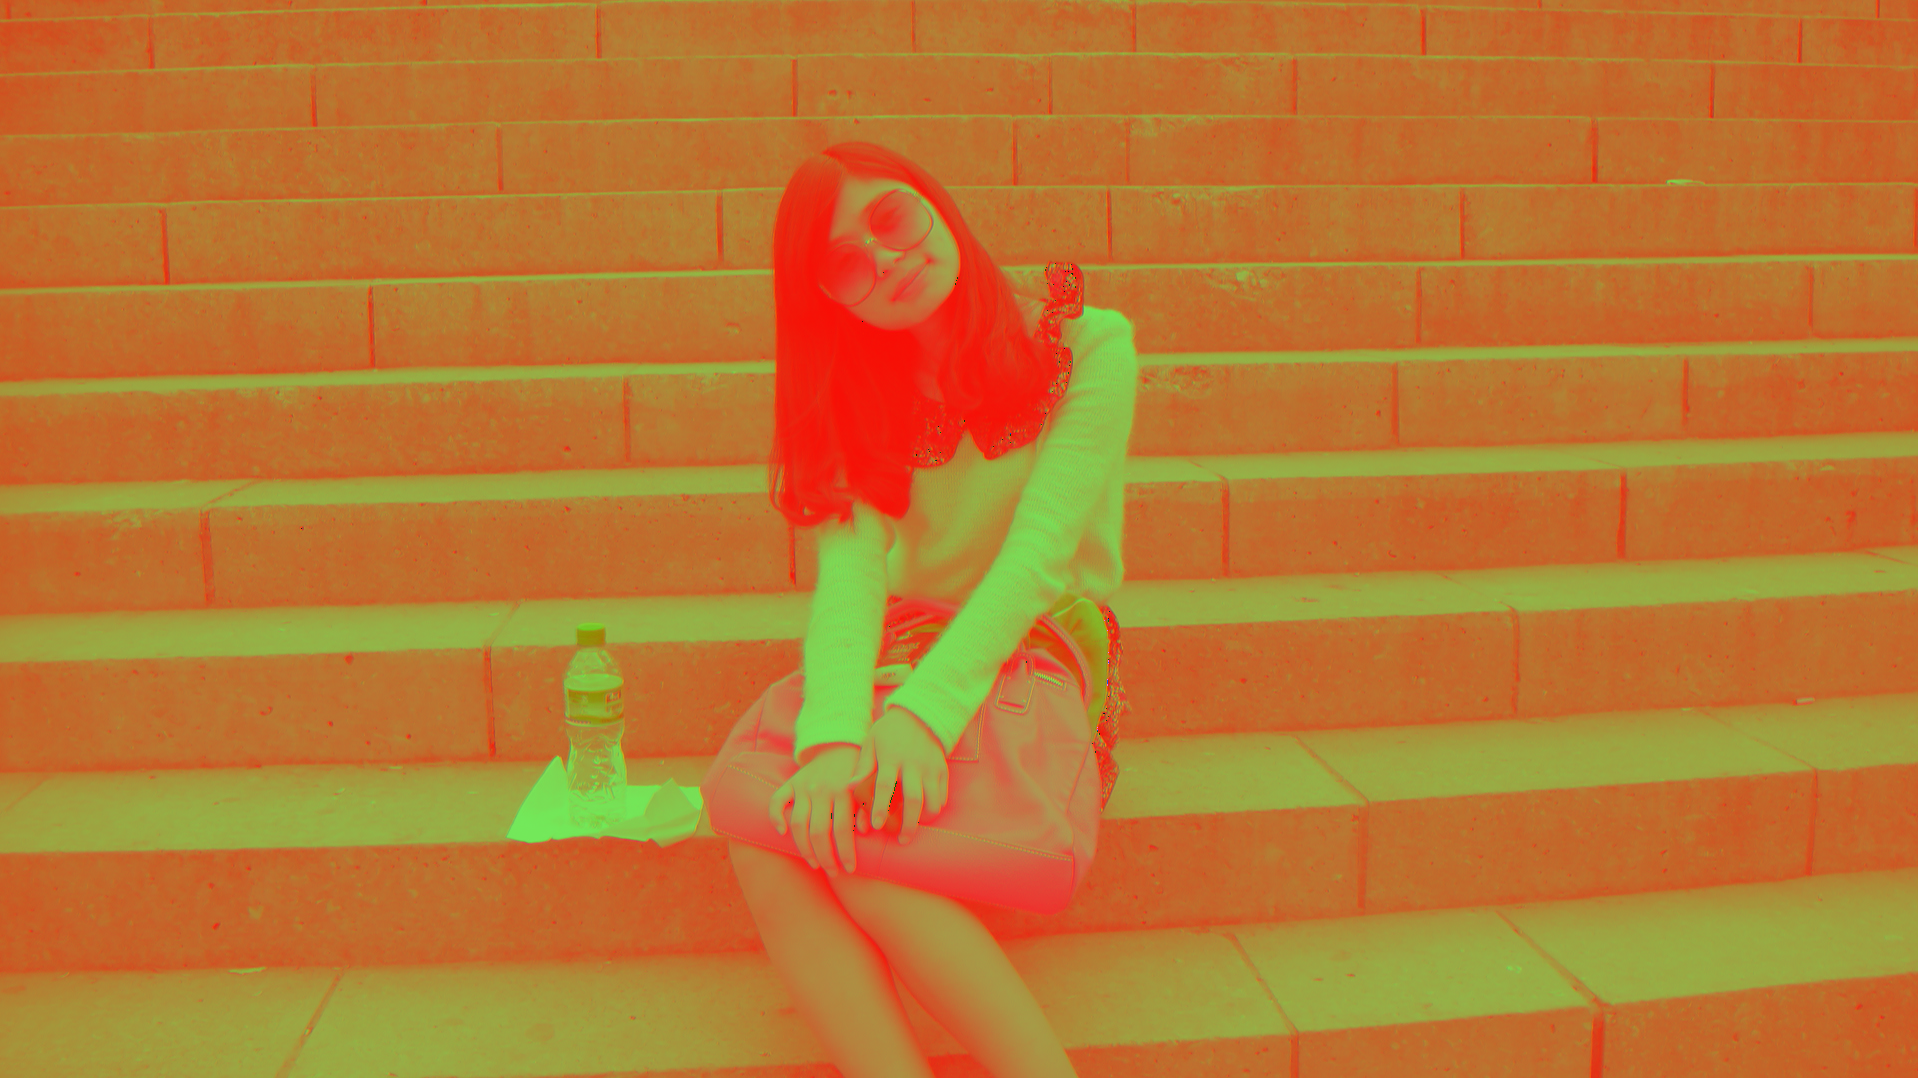

In [31]:
to_pil(out.data.squeeze(0))

In [32]:
pool = t.nn.AvgPool2d(3,3)

In [33]:
out = pool(out)

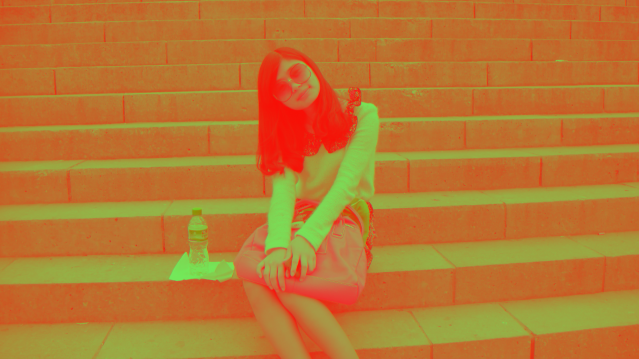

In [34]:
to_pil(out.data.squeeze(0))

In [39]:
k = t.randn(2,3)
k

tensor([[-0.6904, -1.0089, -0.7589],
        [-0.0677, -0.3814,  0.1413]])

In [40]:
k = k.view(3,2)

In [41]:
k

tensor([[-0.6904, -1.0089],
        [-0.7589, -0.0677],
        [-0.3814,  0.1413]])

In [42]:
?? t.nn.BatchNorm1d

#### restnet34

<img align="center" src="http://nbviewer.jupyter.org/github/chenyuntc/pytorch-book/blob/master/chapter4-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B7%A5%E5%85%B7%E7%AE%B1nn/imgs/residual.png">

In [129]:
class Block(t.nn.Module):
    def __init__(self,inchannel,outchannel,stride=1, shortcut=None):
        super(Block,self).__init__()
        self.left = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,3,stride, 1,bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                nn.BatchNorm2d(outchannel) )
        self.right = shortcut
    def forward(self,x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)
    

In [130]:
class RestNet34(t.nn.Module):
    def __init__(self,n_class):
        super(RestNet34,self).__init__()
        
        ## 处理前面几层网络
        self.pre = t.nn.Sequential(
            t.nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            t.nn.BatchNorm2d(64),
            t.nn.ReLU(inplace=True),
            t.nn.MaxPool2d(3, 2, 1))
        
         # 重复的layer，分别有3，4，6，3个residual block
        self.block1 = self._make_layer( 64, 64, 3)
        self.block2 = self._make_layer( 64, 128, 4, stride=2)
        self.block3 = self._make_layer( 128, 256, 6, stride=2)
        self.block4 = self._make_layer( 256, 512, 3, stride=2)
        
        self.fc = t.nn.Linear(512,n_class)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride, bias=False),
                nn.BatchNorm2d(outchannel))
        
        layers = []
        layers.append(Block(inchannel, outchannel, stride, shortcut))
        
        for i in range(1, block_num):
            layers.append(Block(outchannel, outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.pre(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = t.nn.functional.avg_pool2d(x, 7)
        x = x.view(x.size()[0],-1)
        return self.fc(x)

In [131]:
model = RestNet34(10)

In [132]:
x =t.randn(1,3,224,224)
o = model(x)

In [133]:
o

tensor([[ 0.0386,  0.2147, -0.7754, -0.1771,  0.0319, -0.0109,  0.6186, -0.2199,
         -0.0925, -0.3724]], grad_fn=<ThAddmmBackward>)